# **Project Transfer Learning: Sign Analysis**
**Réalise par**:
* ASEEL Mohssine
* BENGHAZALA Bouchra
* HANINE Nadia
* KAMILI Sara
* KEFSI Abderrahmane






## **Introduction au Transfer Learning**

### Concept de Transfer Learning

Le transfert d'apprentissage est une technique en intelligence artificielle où un modèle pré-entraîné sur une grande base de données est réutilisé et adapté pour une nouvelle tâche. Cela permet de tirer parti des connaissances acquises par le modèle sur la tâche initiale, ce qui est particulièrement utile lorsque la nouvelle tâche dispose de données limitées. Le modèle peut être utilisé comme extracteur de caractéristiques ou être ajusté via un fine-tuning, où certaines couches du modèle sont ré-entraînées sur la nouvelle dataset. Cette approche réduit le temps de calcul, améliore les performances et nécessite moins de données par rapport à l'entraînement d'un modèle à partir de zéro.

### Avantages des modèles pré-entraînés pour des tâches spécifiques

Les modèles pré-entraînés offrent plusieurs avantages pour des tâches spécifiques :

* **Gain de temps et de ressources** : Évitent de réentraîner un modèle à partir de zéro.
* **Amélioration de la précision** : Utilisent les connaissances acquises sur de vastes datasets pour améliorer les performances sur des tâches spécifiques.
* **Efficacité avec des données limitées** : Performants même lorsque les données spécifiques sont limitées.
* **Facilité de développement** : Simplifient et accélèrent le processus de développement des solutions d'apprentissage automatique.
* **Meilleure généralisation** : Apprennent des caractéristiques variées et complexes sur des données diversifiées, ce qui améliore la robustesse des modèles.







## **Collecte et Préparation des Données**

In [ ]:
#data
#https://universe.roboflow.com/annotations-90a5w/asl-72izb

Mounted at /content/drive


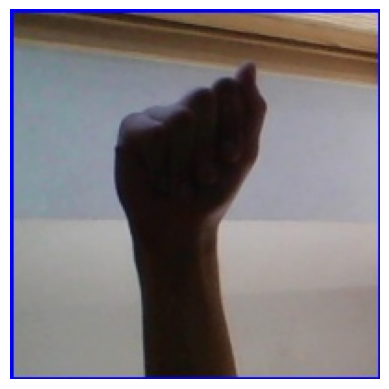

In [ ]:
from google.colab import drive
import os
import zipfile
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier ZIP dans Google Drive
zip_path = '/content/drive/My Drive/ASL.zip'

# Décompresser le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/asl_data')

# Chemins vers les répertoires contenant les images
train_dataset_path = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'
test_dataset_path = '/content/asl_data/asl_alphabet_test/asl_alphabet_test'

# Exemple de chargement et affichage d'une image
#On peut changer le fichier A par les autres fichiers des lettres
image_path = os.path.join(train_dataset_path, 'A', 'A1.jpg')
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()


* ### Augmentation des données par l'approche classique Python



**Importation du module random**: Pour utiliser les fonctions aléatoires telles que random.random(), random.randint(), et random.uniform().

**Fonction augment_image**: Cette fonction applique des transformations aléatoires à une image.
* Rotation: L'image est tournée d'un angle aléatoire compris entre -30 et 30 degrés.
* Retournement horizontal: L'image est retournée horizontalement avec une probabilité de 50%.
* Ajustement de la luminosité: La luminosité de l'image est modifiée de manière aléatoire entre 0,7 et 1,3 fois sa valeur initiale.
* Ajustement du contraste: Le contraste de l'image est modifié de manière aléatoire entre 0,7 et 1,3 fois sa valeur initiale.

**Chemin pour sauvegarder les images augmentées:** Les images augmentées sont sauvegardées dans le répertoire spécifié par augmented_output_path.

**Création du répertoire de sortie:** Si le répertoire de sortie n'existe pas, il est créé.

**Parcours des sous-dossiers et images:** Le script parcourt toutes les images dans le répertoire de formation, applique les augmentations et sauvegarde les images augmentées dans le répertoire de sortie.

**Calcul de la perte moyenne:** Après avoir généré toutes les images augmentées, la fonction evaluate_augmentations est appelée pour calculer la perte de reconstruction moyenne, qui est ensuite affichée.

In [ ]:
import random
# Fonction pour effectuer l'augmentation d'image
def augment_image(image):
    # Rotation
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = image.rotate(angle)

    # Retournement horizontal
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Ajustement de la luminosité
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))

    # Ajustement du contraste
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))

    return image

# Chemin pour sauvegarder les images augmentées
augmented_output_path = '/content/drive/My Drive/Bouchra/augmented_data_python'

# Créer le répertoire de sortie s'il n'existe pas
if not os.path.exists(augmented_output_path):
    os.makedirs(augmented_output_path)

# Parcourir toutes les sous-dossiers et images dans le dataset de formation
for subdir, dirs, files in os.walk(train_dataset_path):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(subdir, file)
            image = Image.open(image_path)

            # Appliquer les augmentations
            for i in range(5):  # Créer 5 versions augmentées de chaque image
                augmented_image = augment_image(image)

                # Chemin pour sauvegarder l'image augmentée
                subfolder_name = os.path.basename(subdir)
                save_dir = os.path.join(augmented_output_path, subfolder_name)
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                save_path = os.path.join(save_dir, f"{os.path.splitext(file)[0]}_aug_{i}.jpg")

                # Sauvegarder l'image augmentée
                augmented_image.save(save_path)

print("Augmentation des données terminée.")

Augmentation des données terminée.


### Augmentation Automatique avec ImageDataGenerator de Keras

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from google.colab import drive
import shutil

# Monter Google Drive
drive.mount('/content/drive')

# Chemins vers les répertoires contenant les images

train_dataset_path = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'

# Définir la taille cible des images pour ResNet50 (224x224)
target_size = (224, 224)

# Fonction pour générer des images augmentées pour chaque image dans un dossier
def generate_augmented_images(image_path, class_name, num_images=5, save_dir='images_data'):
    """
    Génère et sauvegarde des images augmentées pour une classe donnée.

    Args:
        image_path (str): Chemin vers l'image originale.
        class_name (str): Nom de la classe (par exemple, 'A', 'B', 'C').
        num_images (int, optionnel): Nombre d'images augmentées à générer pour chaque image d'origine. Par défaut, 5.
        save_dir (str, optionnel): Répertoire où sauvegarder les images augmentées. Par défaut, 'images_data'.
    """
    # Charger et redimensionner l'image
    img = load_img(image_path, target_size=target_size)
    # Convertir en tableau NumPy
    x = img_to_array(img)
    # Ajouter une dimension de batch
    x = np.expand_dims(x, axis=0)
    # Prétraiter pour ResNet50
    x = preprocess_input(x)

    # Définir le générateur d'images augmentées
    datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.5, 1.5)
    )

    # Créer le répertoire de sauvegarde s'il n'existe pas
    save_dir = os.path.join(save_dir, class_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=save_dir,
                              save_prefix=class_name,
                              save_format='jpeg'):
        i += 1
        if i >= num_images:
            break

# Chemin pour sauvegarder les images augmentées
augmented_output_path = '/content/drive/My Drive/Bouchra/augmented_data_keras'

# Supprimer le répertoire existant s'il existe et le recréer
if os.path.exists(augmented_output_path):
    shutil.rmtree(augmented_output_path)
os.makedirs(augmented_output_path)

# Parcourir toutes les sous-dossiers et images dans le dataset de formation
for subdir, dirs, files in os.walk(train_dataset_path):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(subdir, file)
            class_name = os.path.basename(subdir)  # Extraire class_name du nom du sous-dossier
            generate_augmented_images(image_path, class_name, num_images=5, save_dir=augmented_output_path)

print("Augmentation des données terminée.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Visualisation

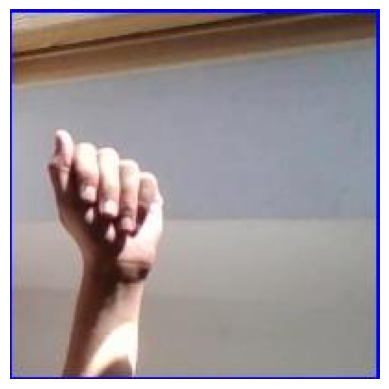

In [ ]:
#Afficher exemple image augmentée:
# Chemins vers les répertoires contenant les images augmentées
train_dataset_path_augmented = '/content/drive/My Drive/Bouchra/augmented_data_python'

# Exemple de chargement et affichage d'une image augmentée
#On peut changer le fichier A par les autres fichiers des lettres
image_aug_path = os.path.join(train_dataset_path_augmented, 'A', 'A1000_aug_1.jpg')
image = Image.open(image_aug_path)

plt.imshow(image)
plt.axis('off')
plt.show()

* ### Augmentation des données par l'approche basée sur les autoencoders



### **Autoencodeur**

Un autoencodeur est un type de réseau de neurones conçu pour apprendre une représentation compressée et efficace des données d'entrée, souvent utilisé pour la réduction de la dimensionnalité ou la détection d'anomalies. Il se compose de deux parties :

l'encodeur, qui transforme l'entrée en une représentation compacte appelée "code" ou "embedding", et le décodeur, qui tente de reconstruire l'entrée originale à partir de cette représentation compacte.

Les autoencodeurs sont utilisés pour des tâches variées comme la réduction de la dimensionnalité, la détection d'anomalies, la génération de nouvelles données similaires aux données d'entraînement et le pré-entraînement des réseaux de neurones profonds.

Par exemple, en réduisant des images de grande dimension à une représentation plus petite, les autoencodeurs permettent de capturer les caractéristiques essentielles des images tout en facilitant leur reconstruction, offrant ainsi une méthode flexible et puissante pour le traitement et l'analyse des données complexes.

* **Chargement des images** : Les images sont chargées à partir du dossier de données d'entraînement et redimensionnées à une taille cible (64x64 ici).
* **Définition de l'autoencodeur** : Un autoencodeur simple est défini avec des couches de convolution et de pooling pour encoder les images, et des couches de convolution et d'upsampling pour les décoder.
* **Entraînement de l'autoencodeur** : L'autoencodeur est entraîné à apprendre une représentation compacte des images et à reconstruire les images originales.
* **Génération des images augmentées** : Les images reconstruites par l'autoencodeur sont considérées comme des données augmentées et sauvegardées dans le répertoire spécifié.
* **Fonction evaluate_generated_images** : Compare chaque image originale avec son équivalent généré et calcule la perte de reconstruction (erreur quadratique moyenne) pour chaque paire.
* **Calcul de la perte moyenne** : La fonction evaluate_generated_images retourne la perte de reconstruction moyenne pour toutes les images générées, ce qui donne une idée de la qualité des images augmentées.
* **Calcul de generated_loss** : La perte de reconstruction moyenne des images générées par rapport aux images d'origine est calculée et affichée pour évaluer la qualité des images augmentées par l'autoencodeur.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img

# Chemins vers les répertoires contenant les images
train_dataset_path = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'
test_dataset_path = '/content/asl_data/asl_alphabet_test/asl_alphabet_test'

# Charger et prétraiter les images
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    paths = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                paths.append(os.path.relpath(img_path, folder))
    return np.array(images), paths

train_images, train_paths = load_images_from_folder(train_dataset_path)
test_images, test_paths = load_images_from_folder(test_dataset_path)

# Définir l'autoencodeur
input_img = Input(shape=(64, 64, 3))

# Encodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# Décodeur
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entraîner l'autoencodeur
autoencoder.fit(train_images, train_images,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images, test_images))

# Évaluer l'autoencodeur sur les données de test
test_loss = autoencoder.evaluate(test_images, test_images)
print(f"Test reconstruction loss: {test_loss}")

# Générer des images augmentées
# augmented_output_path = '/content/asl_data/augmented_data_autoencoders'
augmented_output_path = '/content/drive/My Drive/Bouchra/augmented_data_autoencoders'

# Créer le répertoire de sortie s'il n'existe pas
if not os.path.exists(augmented_output_path):
    os.makedirs(augmented_output_path)

encoded_imgs = autoencoder.predict(train_images)

# Sauvegarder les images générées dans les sous-dossiers correspondants
for i, (img, path) in enumerate(zip(encoded_imgs, train_paths)):
    save_dir = os.path.join(augmented_output_path, os.path.dirname(path))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, os.path.basename(path))
    array_to_img(img).save(save_path)

print("Augmentation des données par autoencodeurs terminée.")

# Évaluer la qualité des images générées
def evaluate_generated_images(original_images, generated_images):
    reconstruction_losses = []
    for orig, gen in zip(original_images, generated_images):
        loss = np.mean((orig - gen) ** 2)
        reconstruction_losses.append(loss)
    return np.mean(reconstruction_losses)

# Calculer la perte de reconstruction moyenne pour les images générées
generated_loss = evaluate_generated_images(train_images, encoded_imgs)
print(f"Generated images reconstruction loss: {generated_loss}")


In [ ]:
#Afficher exemple image augmentée:
# Chemins vers les répertoires contenant les images augmentées
train_dataset_path_augmented = '/content/drive/My Drive/Bouchra/augmented_data_autoencoders'

# Exemple de chargement et affichage d'une image augmentée
#On peut changer le fichier A par les autres fichiers des lettres
image_aug_path = os.path.join(train_dataset_path_augmented,'A', 'A1.jpg')
image = Image.open(image_aug_path)

plt.imshow(image)
plt.axis('off')
plt.show()

NameError: name 'os' is not defined


## **Choix du Modèle Pré-entraîné**


### Sélection du Modèle Pré-entraîné
Pour la tâche de classification d'images de l'alphabet ASL (American Sign Language), nous considérons plusieurs modèles pré-entraînés populaires tels que VGG16, ResNet50, InceptionV3, et EfficientNet. Chacun de ces modèles a ses propres avantages et inconvénients en termes de complexité, de précision et de temps d'inférence.

1. VGG16

Avantages :
Architecture simple et bien connue.
Convient bien pour des tâches de classification avec un nombre modéré de classes.
Facile à comprendre et à implémenter.
Inconvénients :
Modèle volumineux et computationnellement coûteux.
Moins performant sur des tâches très complexes comparé à des modèles plus récents.
Utilisation :
Idéal pour des tâches où la simplicité et l'interprétabilité sont cruciales.
2. ResNet50

Avantages :
Utilise des blocs résiduels permettant de former des réseaux très profonds sans problème de gradient vanishing.
Très performant sur une large gamme de tâches de vision par ordinateur.
Bon équilibre entre profondeur et complexité.
Inconvénients :
Peut être trop complexe pour des tâches avec des données moins variées.
Utilisation :
Adapté pour des tâches nécessitant une profondeur modérée à élevée avec une bonne performance générale.
3. InceptionV3

Avantages :
Combinaison de convolutions de différentes tailles dans le même bloc, permettant d'extraire des caractéristiques à différentes échelles.
Bon compromis entre profondeur et complexité computationnelle.
Inconvénients :
Plus complexe à implémenter et à comprendre par rapport à VGG16.
Utilisation :
Adapté pour des tâches nécessitant l'analyse de caractéristiques multi-échelles dans les images.
4. EfficientNet

Avantages :
Utilise une technique d'ajustement de modèle basée sur la profondeur, la largeur et la résolution, offrant un excellent rapport performance/complexité.
Très efficace en termes de paramètres et de FLOPS.
Inconvénients :
Peut être plus difficile à implémenter et à ajuster par rapport à des modèles plus simples.

Utilisation :
Idéal pour des tâches nécessitant une haute précision avec des contraintes de ressources computationnelles.

Justification du Choix
Pour la tâche spécifique de classification d'images de l'alphabet ASL, nous devons prendre en compte plusieurs facteurs :

Complexité des Données : Les images de l'alphabet ASL peuvent varier en termes de luminosité, d'angles et de tailles des mains, nécessitant un modèle capable de capturer ces variations.
Ressources Computationnelles : Le modèle doit être suffisamment efficace pour s'exécuter sur les ressources disponibles, notamment si nous utilisons des environnements avec des limitations de GPU ou de mémoire.
Performance : Nous visons une haute précision pour distinguer les différentes lettres de l'alphabet ASL, qui peuvent parfois être similaires visuellement.

**Choix Final : ResNet50**

Justification :

Performance : ResNet50 est connu pour sa haute performance sur une variété de tâches de classification d'images, grâce à son architecture profonde utilisant des blocs résiduels.

Complexité : Bien qu'il soit plus complexe que VGG16, il reste raisonnable en termes de ressources comparé à InceptionV3 ou EfficientNet, surtout lorsque l'on dispose de ressources GPU modérées.

Adaptabilité : Les blocs résiduels de ResNet50 permettent d'apprendre des caractéristiques complexes sans problème de gradient vanishing, ce qui est crucial pour distinguer des lettres similaires de l'ASL.

En conclusion, ResNet50 offre un bon équilibre entre performance et complexité pour la tâche de classification des images de l'alphabet ASL, permettant une haute précision avec des ressources computationnelles modérées.

## **Personnalisation du modèle**

In [ ]:
# Nombre de classes pour l'ASL (26 lettres de l'alphabet)
NUM_CLASSES = 29

# Taille des images
IMAGE_RESIZE = 224

# Paramètres pour ResNet50 et le modèle
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

# Paramètres d'entraînement
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
STEPS_PER_EPOCH_TRAINING = 100  # Ajuster selon le nombre d'images d'entraînement
STEPS_PER_EPOCH_VALIDATION = 20  # Ajuster selon le nombre d'images de validation
BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 32
BATCH_SIZE_TESTING = 1

train_dataset_path = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'
test_dataset_path = '/content/asl_data/asl_alphabet_test/asl_alphabet_test'

# Chemins des données
TRAIN_DIR = train_dataset_path
TEST_DIR = test_dataset_path


In [ ]:
from google.colab import drive
import os
import zipfile
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# Chargement des poids de ResNet50 à partir du fichier spécifique
resnet_weights_path = 'xyz_tf_kernels_NOTOP.h5'

# Création du modèle
model = Sequential()
model.add(ResNet50(include_top=False, pooling=RESNET50_POOLING_AVERAGE, weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))

# Désactivation de l'entraînement de la première couche (ResNet) car elle est déjà entraînée
model.layers[0].trainable = False

# Compilation du modèle
model.compile(optimizer='adam', loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)


In [ ]:
from google.colab import drive
import os
import zipfile
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# Générateurs d'images pour l'entraînement, la validation et le test
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
    batch_size=BATCH_SIZE_TESTING,
    class_mode='categorical'
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 0 images belonging to 1 classes.


In [ ]:
num_test_images = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
print(f"Number of test images: {num_test_images}")
assert num_test_images > 0, "No test images found."

Number of test images: 29


In [ ]:
import tensorflow as tf
# Entraînement du modèle avec validation
model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    validation_data=val_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
    ]
)

# Évaluation du modèle sur les données de test
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Affichage des couches de ResNet50
for i, layer in enumerate(model.layers[0].layers):
    print(f"Layer {i}: {layer.name} - Trainable: {layer.trainable}")


Epoch 1/10
100/100 [==============================] - 24s 151ms/step - loss: 3.3990 - accuracy: 0.0434 - val_loss: 3.3572 - val_accuracy: 0.0312
Epoch 2/10
100/100 [==============================] - 13s 132ms/step - loss: 3.2962 - accuracy: 0.0781 - val_loss: 3.3179 - val_accuracy: 0.0625
Epoch 3/10
100/100 [==============================] - 14s 136ms/step - loss: 3.2488 - accuracy: 0.0822 - val_loss: 3.2926 - val_accuracy: 0.0500
Epoch 4/10
100/100 [==============================] - 14s 137ms/step - loss: 3.2022 - accuracy: 0.1106 - val_loss: 3.2886 - val_accuracy: 0.0906
Epoch 5/10
100/100 [==============================] - 13s 133ms/step - loss: 3.1599 - accuracy: 0.1091 - val_loss: 3.2932 - val_accuracy: 0.0703
Epoch 6/10
100/100 [==============================] - 13s 133ms/step - loss: 3.1223 - accuracy: 0.1412 - val_loss: 3.2324 - val_accuracy: 0.0906
Epoch 7/10
100/100 [==============================] - 14s 137ms/step - loss: 3.0830 - accuracy: 0.1469 - val_loss: 3.2196 - val_ac

ValueError: Asked to retrieve element 0, but the Sequence has length 0